In [6]:
import umap
import umap.plot

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from VPTDataset import VPTDataset

/homes/jwuelfingen/anaconda3/envs/ts-bc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/homes/jwuelfingen/anaconda3/envs/ts-bc/lib/python3.9/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [7]:
dataset = VPTDataset()
episode_starts = np.load('weights/ts_bc/episode_starts.npy', allow_pickle=True)
latents_vpt = np.load('weights/ts_bc/latents_vpt.npy', allow_pickle=True)
print(episode_starts.shape, latents_vpt.shape)

(200, 2) (983849, 1024)


In [17]:
EPISODE_RANGE = [20, 30]  # [a, b)
idx_selection_start, idx_selection_end = int(episode_starts[EPISODE_RANGE[0]][1]), int(episode_starts[EPISODE_RANGE[1]][1])

video_list, actions_list = [], []
for i in tqdm(range(*EPISODE_RANGE)):
    vid, actions, _ = dataset.get_from_vid_id(episode_starts[i][0])
    video_list.append(vid)
    actions_list.append(actions)

100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


In [18]:
videoIndices = np.zeros((latents_vpt.shape[0],))
frames = list(map(lambda x: int(x), list(episode_starts[:, 1]))) + [latents_vpt.shape[0]]
for i in range(len(episode_starts)):
    videoIndices[frames[i]:frames[i+1]] = i

### UMAP Input

In [19]:
data_selection = latents_vpt[idx_selection_start : idx_selection_end]
len(data_selection)

50938

In [20]:
label_videoIndices = videoIndices[idx_selection_start : idx_selection_end]
len(label_videoIndices)

50938

In [26]:
SEA_LEVEL = 60

label_isUnderSeaLevel = []
for i in tqdm(range(EPISODE_RANGE[1] - EPISODE_RANGE[0])):
    actions = actions_list[i]
    for j in range(15, len(actions)):
        label_isUnderSeaLevel.append(int(actions[j]['ypos'] < SEA_LEVEL))
    label_isUnderSeaLevel.append(int(actions[j]['ypos'] < SEA_LEVEL))
len(label_isUnderSeaLevel)

100%|██████████| 10/10 [00:00<00:00, 447.98it/s]


50938

In [56]:
def is_in_inv(frame):
    return  frame[101][640//2][0] == 197 \
        and frame[101][640//2][1] == 197 \
        and frame[101][640//2][2] == 197 \
        and frame[101][640//2+2][0] == 197 \
        and frame[101][640//2+2][1] == 197 \
        and frame[101][640//2+2][2] == 197

label_isInInv = []
for vid in video_list:
    for frame_idx in range(15, len(vid)):
        label_isInInv.append(int(is_in_inv(vid[frame_idx])))
len(label_isInInv)

50938

### Compute UMAP

In [23]:
mapper = umap.UMAP().fit(data_selection)

/homes/jwuelfingen/anaconda3/envs/ts-bc/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Videos


<Axes: >

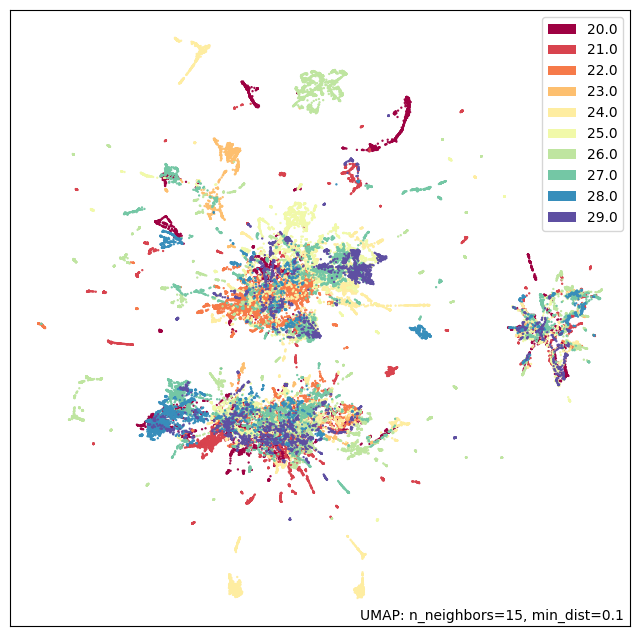

In [24]:
print('Videos')
umap.plot.points(mapper, labels=np.array(label_videoIndices))

Under Sea Level


<Axes: >

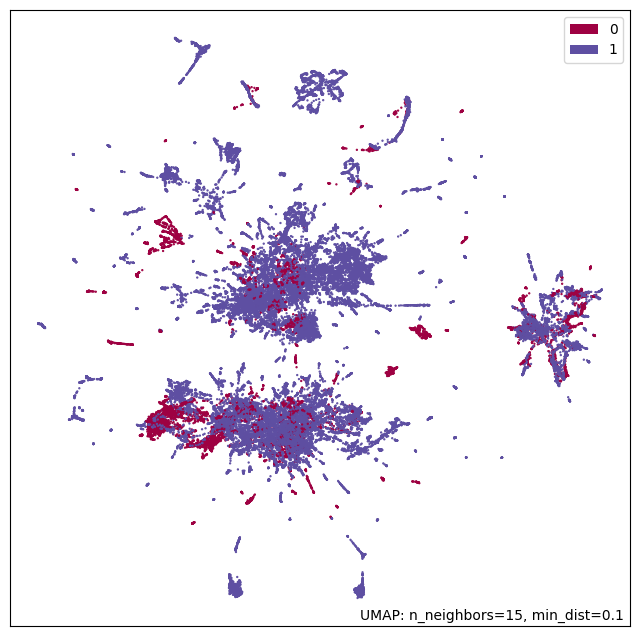

In [27]:
print('Under Sea Level')
umap.plot.points(mapper, labels=np.array(label_isUnderSeaLevel))

Is in Inventory


<Axes: >

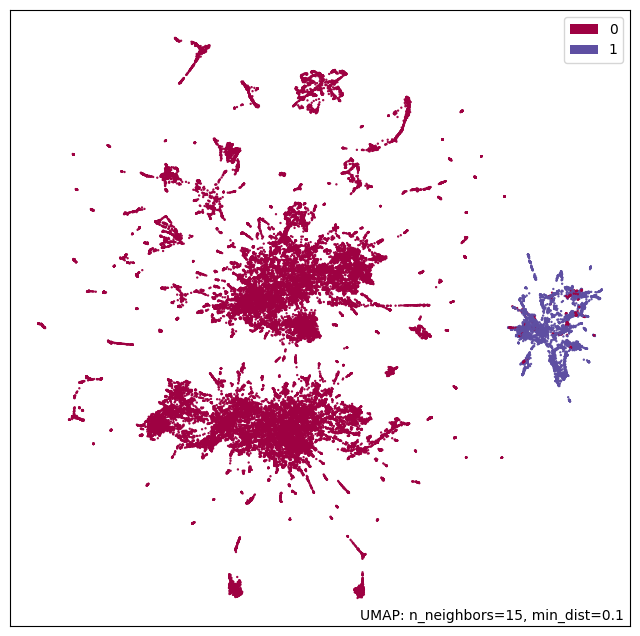

In [57]:
print('Is in Inventory')
umap.plot.points(mapper, labels=np.array(label_isInInv))

### Testing

In [28]:
vid0 = video_list[0]
vid0.shape

(6001, 360, 640, 3)

In [29]:
episode_starts[20][0]

'data/10.0/shabby-viridian-beaver-f153ac423f61-20220419-133719'

In [30]:
import cv2
vid0frame0 = vid0[0]
vid0frame0.shape

(360, 640, 3)

In [50]:
for h in range(101, 102):
    print(vid0[1][h][640//2-3])

[197 197 197]


In [52]:
vid0[0][101][640//2] == [197, 197, 197]

array([ True,  True,  True])